c:\Users\Kilian\thesis\progno_env\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


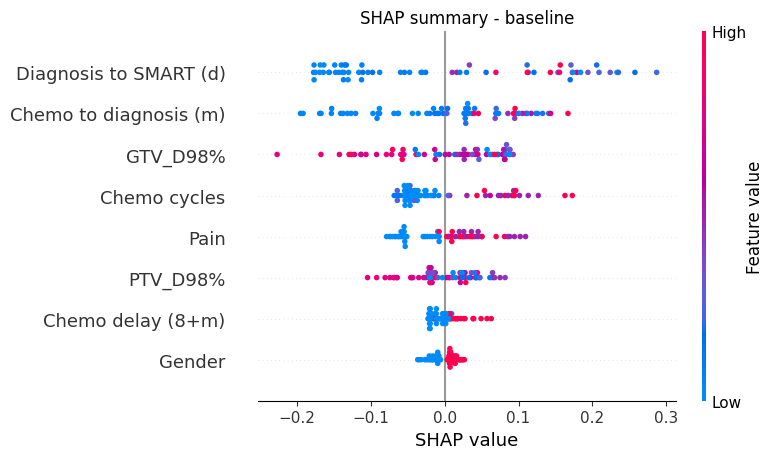

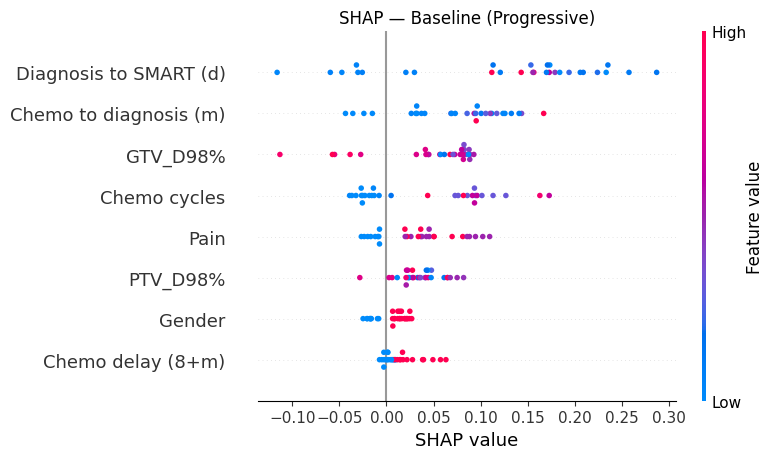

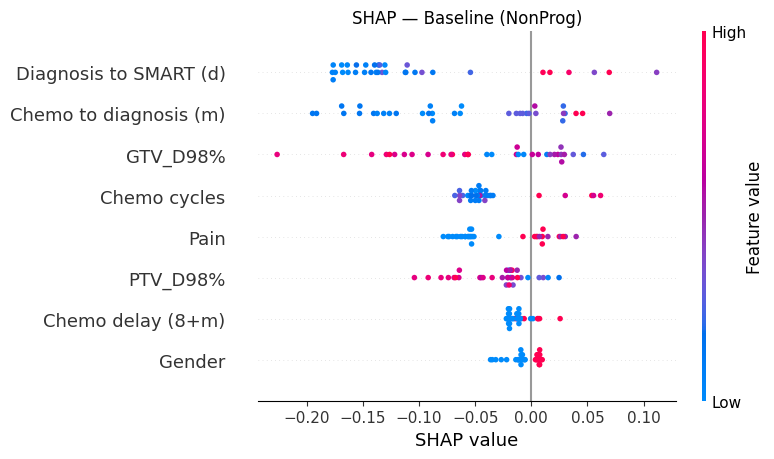

Saved SHAP plots in shap_plots


c:\Users\Kilian\thesis\progno_env\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


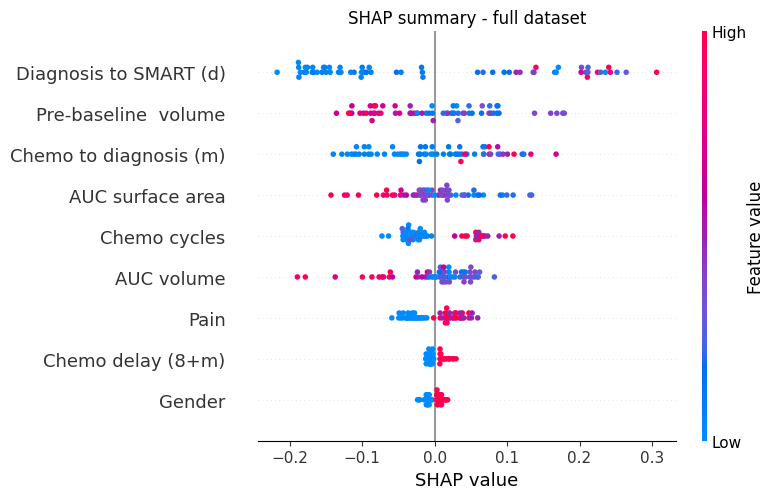

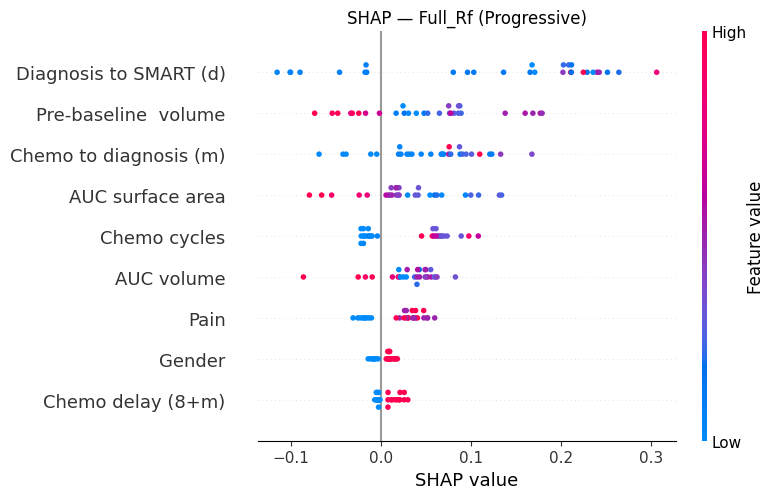

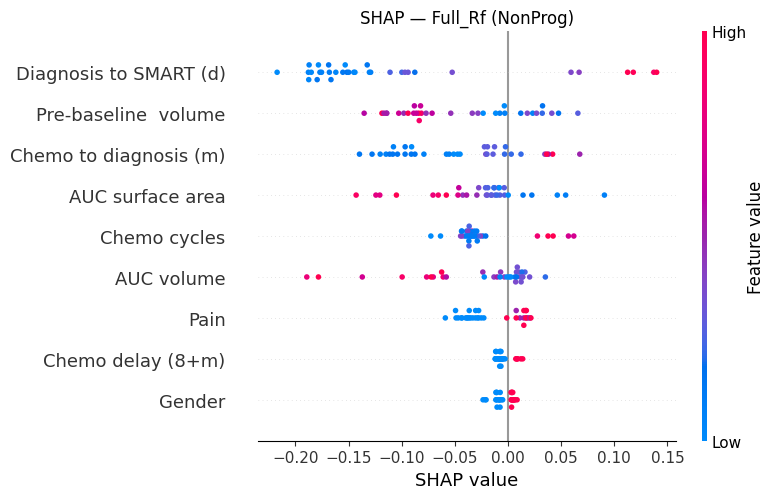

Saved SHAP plots in shap_plots


In [1]:
import os
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import ranksums

class WilcoxonCollinearPruner(BaseEstimator, TransformerMixin):
    def __init__(self, k=10, corr_thresh=0.9):
        self.k = k
        self.corr_thresh = corr_thresh

    def fit(self, X, y):
        df = pd.DataFrame(X, columns=getattr(X, 'columns',
                                           [f'f{i}' for i in range(X.shape[1])]))
        yarr = np.asarray(y)
        pvals = []
        for c in df.columns:
            v0, v1 = df.loc[yarr==0, c], df.loc[yarr==1, c]
            if v0.std() == 0 and v1.std() == 0:
                pvals.append(1.0)
            else:
                _, p = ranksums(v0, v1)
                pvals.append(p)
        self.pvals_ = np.array(pvals)

        corr = df.corr().abs().values
        to_drop = set()
        idxs = np.arange(df.shape[1])
        for i, j in zip(*np.triu_indices(len(idxs), k=1)):
            if corr[i, j] > self.corr_thresh:
                drop = i if self.pvals_[i] > self.pvals_[j] else j
                to_drop.add(drop)

        kept = [i for i in idxs if i not in to_drop]
        kept = sorted(kept, key=lambda i: self.pvals_[i])[: self.k]
        self.selected_ = kept
        self.n_features_in_ = df.shape[1]
        return self

    def transform(self, X):
        return np.asarray(X)[:, self.selected_]

    def get_support(self, indices=False):
        if indices:
            return self.selected_
        mask = np.zeros(self.n_features_in_, bool)
        mask[self.selected_] = True
        return mask


def shap_for_model(
    df_path: str,
    best_params: dict,
    pruner_k: int,
    model_type: str,       # "baseline" or "full"
    log_dir: str = "shap_plots",
    out_prefix: str = "model"
):
    os.makedirs(log_dir, exist_ok=True)

    # 1) load + clean
    df = pd.read_csv(df_path)
    dfc = df.drop(columns=['Local_PD'], errors='ignore') \
             .dropna(axis=1, how='all')
    y = dfc['Progressive'].values
    X = dfc.drop(columns=['Progressive','research ID'], errors='ignore')

    # 2) choose classifier
    if model_type in ("baseline", "full"):
        clf = RandomForestClassifier(random_state=42, **best_params)
    else:
        clf = XGBClassifier(
            use_label_encoder=False,
            eval_metric='auc',
            random_state=42,
            **best_params
        )

    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('var',     VarianceThreshold(1e-2)),
        ('select',  WilcoxonCollinearPruner(k=pruner_k)),
        ('scale',   StandardScaler()),
        ('clf',     clf)
    ])

    # 3) fit
    pipe.fit(X, y)

    # 4) assemble final feature matrix
    X_imp = pd.DataFrame(pipe.named_steps['imputer'].transform(X),
                         columns=X.columns)
    mask_var = pipe.named_steps['var'].get_support()
    X_var = X_imp.loc[:, mask_var]
    sel_idxs = pipe.named_steps['select'].get_support(indices=True)
    X_sel = X_var.iloc[:, sel_idxs]
    X_scl = pd.DataFrame(pipe.named_steps['scale'].transform(X_sel),
                         columns=X_sel.columns)

    # 4.5) rename for prettier SHAP labels
    rename_map = {
        "dx_to_SMART_days":         "Diagnosis to SMART (d)",
        "Timefromchemo":            "Chemo to diagnosis (m)",
        "Numb_cycles":              "Chemo cycles",
        "Delayfromchemo":           "Chemo delay (8+m)",
        "gender_0":                 "Gender",
        "vol_pre1":                 "Pre-baseline  volume",
        "vol_auc":                  "AUC volume",
        "area_auc_pre":              "AUC surface area", 
    }
    X_scl = X_scl.rename(columns=rename_map)

    # 5) explain
    explainer = shap.TreeExplainer(pipe.named_steps['clf'], X_scl)
    shap_vals = explainer.shap_values(X_scl)
    if isinstance(shap_vals, list):
        shap_pos = shap_vals[1]
    else:
        arr = np.array(shap_vals)
        shap_pos = arr[:, :, 1] if arr.ndim == 3 else arr

    # determine descriptor for title
    descriptor = "baseline" if model_type == "baseline" else "full dataset"

    # 6) overall beeswarm
    plt.figure(figsize=(8,6))
    shap.summary_plot(
        shap_pos,
        X_scl,
        feature_names=X_scl.columns.tolist(),
        plot_type="dot",
        show=False
    )
    plt.title(f"SHAP summary - {descriptor}")
    plt.xlabel("SHAP value")
    plt.tight_layout()
    fname = os.path.join(log_dir, f"{out_prefix}_shap_summary.png")
    plt.savefig(fname, dpi=150)
    plt.show()
    plt.close()

    # 7) class‐specific
    for cls_name, mask in [("Progressive", y==1), ("NonProg", y==0)]:
        plt.figure(figsize=(8,6))
        shap.summary_plot(
            shap_pos[mask],
            X_scl.iloc[mask],
            feature_names=X_scl.columns.tolist(),
            plot_type="dot",
            show=False
        )
        # you can adjust these similarly if you like
        plt.title(f"SHAP — {out_prefix.title()} ({cls_name})")
        plt.xlabel("SHAP value")
        plt.tight_layout()
        fname = os.path.join(log_dir, f"{out_prefix}_shap_{cls_name}.png")
        plt.savefig(fname, dpi=150)
        plt.show()
        plt.close()

    print("Saved SHAP plots in", log_dir)


# ─────────── Example usage ───────────

baseline_params = {
    "bootstrap": False,
    "max_depth": 5,
    "max_features": "log2",
    "min_samples_leaf": 1,
    "min_samples_split": 6,
    "n_estimators": 242
}
shap_for_model(
    df_path     = "BASELINE2_NO_SEGS.csv",
    best_params = baseline_params,
    pruner_k    = 8,
    model_type  = "baseline",
    log_dir     = "shap_plots",
    out_prefix  = "baseline"
)

rf_classifier_params = {
    "bootstrap": True,
    "max_depth": 20,
    "max_features": None,
    "min_samples_leaf": 1,
    "min_samples_split": 4,
    "n_estimators": 135
}
shap_for_model(
    df_path     = "BASELINE2_FINALDATA9.csv",
    best_params = rf_classifier_params,
    pruner_k    = 9,
    model_type  = "full",
    log_dir     = "shap_plots",
    out_prefix  = "full_rf"
)


c:\Users\Kilian\thesis\progno_env\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

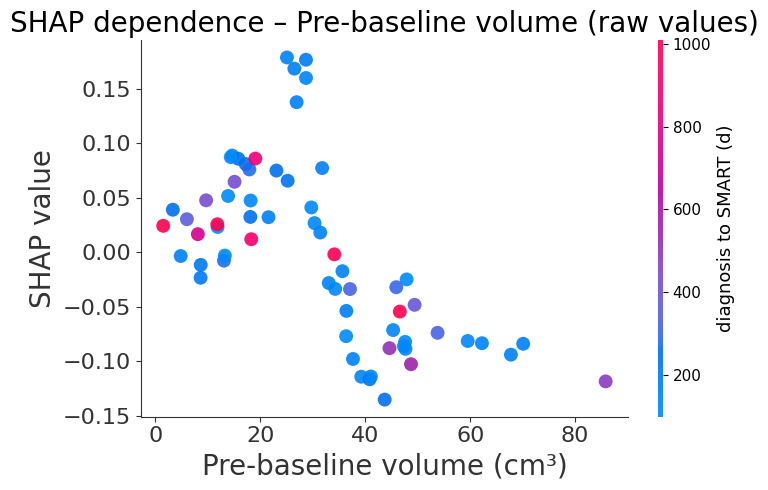

In [ ]:
import os
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import ranksums

# ─── Helper class ────────────────────────────────────────────────────────────────
class WilcoxonCollinearPruner(BaseEstimator, TransformerMixin):
    def __init__(self, k=10, corr_thresh=0.9):
        self.k = k
        self.corr_thresh = corr_thresh

    def fit(self, X, y):
        df = pd.DataFrame(
            X, 
            columns=getattr(X, 'columns', [f'f{i}' for i in range(X.shape[1])])
        )
        yarr = np.asarray(y)
        pvals = []
        for c in df.columns:
            v0, v1 = df.loc[yarr == 0, c], df.loc[yarr == 1, c]
            pvals.append(1.0 if v0.std() == 0 and v1.std() == 0 else ranksums(v0, v1)[1])
        self.pvals_ = np.array(pvals)

        corr = df.corr().abs().values
        to_drop = set()
        idxs = np.arange(df.shape[1])
        for i, j in zip(*np.triu_indices(len(idxs), 1)):
            if corr[i, j] > self.corr_thresh:
                drop = i if self.pvals_[i] > self.pvals_[j] else j
                to_drop.add(drop)

        kept = sorted([i for i in idxs if i not in to_drop], key=lambda i: self.pvals_[i])[: self.k]
        self.selected_ = kept
        self.n_features_in_ = df.shape[1]
        return self

    def transform(self, X):
        return np.asarray(X)[:, self.selected_]

    def get_support(self, indices=False):
        if indices:
            return self.selected_
        mask = np.zeros(self.n_features_in_, bool)
        mask[self.selected_] = True
        return mask

# ─── 1) Load & preprocess ──────────────────────────────────────────────────────
df = pd.read_csv("BASELINE2_FINALDATA9.csv")
dfc = df.drop(columns=['Local_PD'], errors='ignore').dropna(axis=1, how='all')
y   = dfc['Progressive'].values
X   = dfc.drop(columns=['Progressive','research ID'], errors='ignore')

pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('var',     VarianceThreshold(1e-2)),
    ('select',  WilcoxonCollinearPruner(k=9)),
    ('scale',   StandardScaler()),
    ('clf',     RandomForestClassifier(
        random_state=42,
        bootstrap=True, max_depth=20, max_features=None,
        min_samples_leaf=1, min_samples_split=4, n_estimators=135
    ))
])
pipe.fit(X, y)

# ─── 2) Assemble scaled & raw feature matrices ─────────────────────────────────
# Raw selected (imputed + var-thresh + collinear-pruned), before scaling
X_imp = pd.DataFrame(pipe.named_steps['imputer'].transform(X), columns=X.columns)
X_var = X_imp.loc[:, pipe.named_steps['var'].get_support()]
X_sel = X_var.iloc[:, pipe.named_steps['select'].get_support(indices=True)]

# Scaled selected, for SHAP
X_scl = pd.DataFrame(
    pipe.named_steps['scale'].transform(X_sel),
    columns = X_sel.columns
)

# Rename columns for readability
rename_map = {
    "dx_to_SMART_days": "diagnosis to SMART (d)",
    "Timefromchemo":    "Days from chemo to diagnosis (m)",
    "Numb_cycles":      "# of chemo cycles",
    "Delayfromchemo":   "binary if SMART delayed (8+m)",
    "gender_0":         "gender",
    "vol_pre1":         "Pre-baseline volume",
    "area_auc_pre":     "AUC surface area",
    "vol_auc":          "AUC volume"
}
X_scl = X_scl.rename(columns=rename_map)
X_raw = X_sel.rename(columns=rename_map)  # raw values, same columns

# ─── 3) Compute SHAP values ─────────────────────────────────────────────────────
explainer = shap.TreeExplainer(pipe.named_steps['clf'], X_scl)
shap_vals = explainer.shap_values(X_scl)
shap_pos = shap_vals[1] if isinstance(shap_vals, list) else (
    np.array(shap_vals)[:,:,1] if np.array(shap_vals).ndim==3 else np.array(shap_vals)
)

# ─── 4) Plot dependence with raw values ─────────────────────────────────────────
# ─── Big SHAP Dependence Plot ───────────────────────────────────────────────
os.makedirs("shap_plots_raw", exist_ok=True)
feat = "Pre-baseline volume"

plt.figure(figsize=(10, 8))
shap.dependence_plot(
    feat,
    shap_pos,
    X_raw,
    interaction_index="diagnosis to SMART (d)",
    dot_size=100,
    alpha=0.9,
    show=False
)
plt.title("SHAP dependence – Pre-baseline volume (raw values)", fontsize=20)
plt.xlabel("Pre-baseline volume (cm³)", fontsize=20)
plt.ylabel("SHAP value", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("shap_plots_raw/dependence_prebaseline_raw_big.png", dpi=150)
plt.show()
plt.close()